Guide for the code: https://www.tensorflow.org/tutorials/images/transfer_learning

**Transfer Learning and Fine Tuning**

Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

Path_to_zip searches for the .zip file and with extract=true, extracts the content within the .zip file. 

Then, a new path is created and added train or validation, and then stored as training and validation data, respectively.

Finally, the size of the images and the batch size are selected (batches are subdivisions of the training dataset, so the model updates the values for each subdivision and not the entire set of data/images. This reduces the use of memory and improves efficiency).

tf.keras.utils.image_dataset_from_directory: generates a dataset for images, and automatically assigns 0 or 1 for each example if binary, or even other values depending on the dataset and the type of classification. This is used in the training set to get the dataset.


Shuffle = True: makes the order random. If false, data is arranged in alphanumeric order.

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 2s 0us/step
Found 2000 files belonging to 2 classes.


Same thing is done for the validation set.

In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Since we do not have a test set (Test set is used to evaluate the model), we must create one, taking 20% (1/5) of the validation set. To do this, the total values in the validation set is obtained with tf.data.experimental.cardinality and the .take() function.

This values are then removed from the validation set with the .skip() function.

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Then, we print the total batches for the validation and test sets.

In [5]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


Data Augmentation

This technique consists in generating synthetic examples by making transformations (rotations, flips, etc.) on images in the original dataset. This makes the model more robust and avoids overfitting, as explained in the tutorial.

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Loading pre-trained model, with rescaled values between [0, 255].

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Creating base model, since the last classification layer is not useful, it is removed with the include_top = false.

This model will extract features from the images, and create a feature vector of 5x5x1280 for each image.

In [8]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


Making the base model untrainable.

In [9]:
base_model.trainable = False

Base Model summary

In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Prediction model

Data augmentation is applied to the input, then the values are converted from [0,1] to [0,255] using preprocess_input.

This values are passed to the base model, with the training parameter set to false to avoid problems with Batch Normalization. Then, a 2D Pooling layer is applied to transform the shape of the inputs from (32x5x5x1280) to (32,1280), with a Dropout of 0.2. Finally, a single Dense neuron without activation computes the output, and 0 is predicted for negative values, and 1 for positive values.

In [11]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

The model is compiled with Adam optimizer, learning rate of 1e-4, and binary crossentropy. Since there is no activation on the last dense neuron, and the values are not normalized, logits is set to true.

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

New model summary and Training using Fit().

In [13]:
model.summary()
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

Plotting the learning curves.

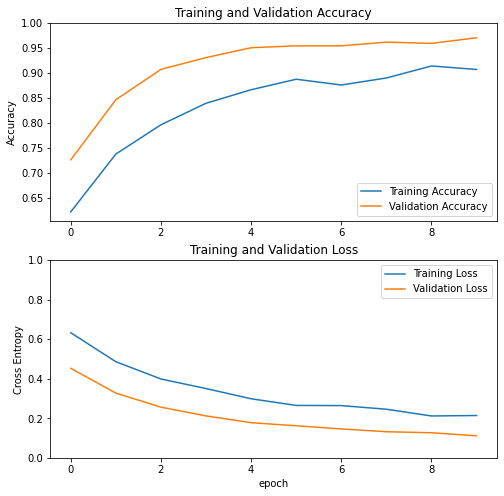

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine_tuning of the model, modifying the weights of the last 34 layers (120 to 154). Setting base_model as trainable now to modify the last weights.

In [15]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

#Layers Trained
l_trained = len(base_model.layers)- fine_tune_at
print("Total of layers trained: ", l_trained)

Number of layers in the base model:  154
Total of layers trained:  34


Since the base model has Batch Normalization, it is important to set layer.trainable = False when calling the base model, to not destroy the learned weights in the new model.

In [16]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Model

Data augmentation is applied to the input, then the values are converted from [0,1] to [0,255] using preprocess_input.

This values are passed to the base model, with the training parameter set to false to avoid problems with Batch Normalization. Then, a 2D Pooling layer is applied to transform the shape of the inputs from (32x5x5x1280) to (32,1280), with a Dropout of 0.2. Finally, a single Dense neuron without activation computes the output, and 0 is predicted for negative values, and 1 for positive values.

In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(8)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

The model is compiled with Adam optimizer, learning rate of 1e-4 (lowered to 1e-5 after testing), and binary crossentropy. Since there is no activation on the last dense neuron, and the values are not normalized, logits is set to true.

In [18]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model parameters and training using fit()


In [19]:
model.summary()
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

Plotting the learning curves

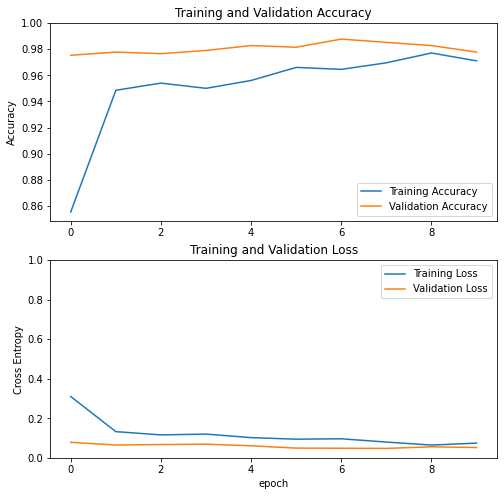

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

With this model, we evaluated the test set.

In [21]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 53ms/step - loss: 0.0786 - accuracy: 0.9740
Test accuracy : 0.9739583134651184


Then, we make predictions on our test set. The predictions are passed through a sigmoid function, and those values above 0.5 will be classified as 1, those below as a 0. Finally, each image with the respective label is plotted.

Predictions:
 [1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1]
Labels:
 [1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1]


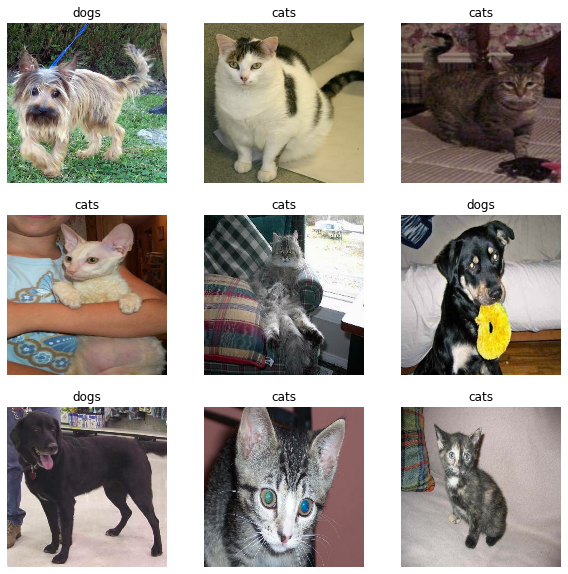

In [22]:
class_names = train_dataset.class_names

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Since fine-tuning produces better results than just use transfer learning without updating the pre-trained model weights, we directly used the fine-tuning model as the base for modifications. 

Final Analysis

The results obtained on the validation set were similar to those obtained by the tutorial:

95,9% for the transfered learning model.

98,2% for the fine-tuned model. (With fine_tune_at = 120)

For different values of fine_tune_at, we obtained the following results (Fine-tuned model only):

fine_tune_at = 50: 96,6%

fine_tune_at = 100: 97,6%

According to the results obtained, if more parameters of the base model are trained, the new model peforms worse. When changing weights of the base model, it is better to only change the last few layers. Selecting too many or too few layers as trainable decreases validation accuracy.

Improvements on the model:
The best model was:
fine_tune_at = 120, increased number of hidden layers before the output dense, adding 1 hidden layer of 8 neurons, learning rate lowered to 1e-5, and lower dropout (0.1), with a validation accuracy of 98,5%.

On the test set, the accuracy is of 99,4%.
